In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
import threading

In [3]:
import pathlib
data_dir = "leaf_photos"
data_dir = pathlib.Path(data_dir)

now have a copy of the dataset available.

In [4]:
# image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)

Here are some bactrial spot:

In [5]:
# bacterial_spots = list(data_dir.glob('Tomato_Bacterial_Spot/*'))
# PIL.Image.open(str(bacterial_spots[0]))

In [6]:
# PIL.Image.open(str(bacterial_spots[1]))

And some healthy:

In [7]:
# healthys = list(data_dir.glob('Tomato_Healthy/*'))
# PIL.Image.open(str(healthys[0]))

In [8]:
# PIL.Image.open(str(healthys[1]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6268 files belonging to 16 classes.
Using 5015 files for training.


In [11]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)

You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [12]:
class_names = train_ds.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Carpetweeds', 'Crabgrass', 'Goosegrass', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Tomato_Bacterial_Spot', 'Tomato_Early_Blight', 'Tomato_Healthy', 'Tomato_Leaf_mold', 'Tomato_Septorial_Leaf_Spot', 'Tomato_Yellow_Leaf_Curl_Virus']


## Visualize the data

Here are the first 9 images from the training dataset.

In [13]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [14]:
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 


In [15]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [16]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [17]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image)) 

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [18]:
batch_size = 32
img_height = 180
img_width = 180

In [19]:
num_classes = 16

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.load_weights('my_checkpoint.ckpt')

## Predict on new data

Note: Data augmentation and Dropout layers are inactive at inference time.

In [21]:
def test_image(test_image_path):
    img = keras.preprocessing.image.load_img(
        test_image_path, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print("\n\n======================================")
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    
    PIL.Image.open(test_image_path)
    
    return class_names[np.argmax(score)]



This image most likely belongs to Tomato_Septorial_Leaf_Spot with a 99.07 percent confidence.


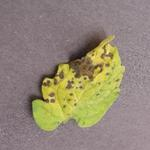

In [22]:
test_image_path = "septorial_leaf_spot.jpg"
test_image(test_image_path)
PIL.Image.open(test_image_path)

In [23]:
from ipywidgets import FileUpload
from IPython.display import display
from PIL import Image
import io
import requests

# Create a file upload widget
upload_widget = FileUpload(accept='image/*', multiple=False)

url = "http://192.168.1.1/act?detect_btn="

def on_upload_change(change):
    
    weed_names = ['Carpetweeds', 'Crabgrass', 'Goosegrass']
    
    save_path = "uploaded.jpg"
    # print(upload_widget)
    image_data = upload_widget.value
    # print(image_data)
    file_info = image_data[0]
    # Access individual fields
    file_name = file_info['name']
    file_type = file_info['type']
    file_size = file_info['size']
    image_data = file_info['content'] 
    image = Image.open(io.BytesIO(image_data))
    # Save the image to a file
    image.save(save_path)
    result = test_image(save_path)
    # Re-open and display the saved image
    saved_image = Image.open(save_path)
    display(saved_image)
    
    for weed_name in weed_names:
        try:
            if weed_name == result:
                resp = requests.get(url+"Detected!")
                print(resp.text)
            else:
                resp = requests.get(url+"Not Detected")
                print(resp.text)
        except:
            print("http error please check system is connected to hotspot name weedrobot")
            


upload_widget.observe(on_upload_change, names='value')
# Display the upload widget
display(upload_widget)


FileUpload(value=(), accept='image/*', description='Upload')

Image captured and saved as captured.jpg


This image most likely belongs to Carpetweeds with a 89.19 percent confidence.


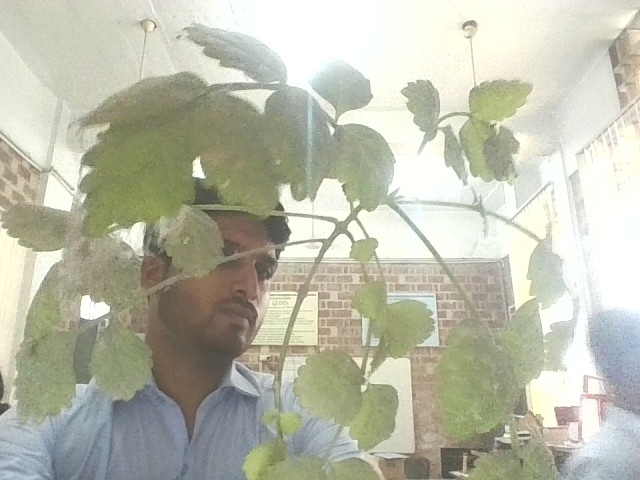

Carpetweeds


In [ ]:
import cv2
from IPython.display import display, Javascript
from IPython.display import clear_output
from IPython.display import clear_output

# Dummy my_predict function (you should define your real function here)
def my_predict():
    weed_names = ['Carpetweeds', 'Crabgrass', 'Goosegrass']
    save_path = "captured.jpg"
    result = test_image(save_path)
    # Re-open and display the saved image
    saved_image = Image.open(save_path)
    display(saved_image)
    print(result)
    
#     for weed_name in weed_names:
#         try:
#             if weed_name == result:
#                 resp = requests.get(url+"Detected!")
#                 print(resp.text)
#             else:
#                 resp = requests.get(url+"Not Detected")
#                 print(resp.text)
#         except:
#             print("http error please check system is connected to hotspot name weedrobot")

# Function to capture photo
def capture_from_camera():
    q1 = 0
    
    cap = cv2.VideoCapture(q1)

    if not cap.isOpened():
        print("Cannot open camera")
        return

    print("Press 'c' or 'C' to capture an image. Press 'q' to quit without capturing.")

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Can't receive frame. Exiting ...")
            break

        cv2.imshow('Live Camera - Press c or C to Capture', frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('c') or key == ord('C'):
            clear_output(wait=True)
            cv2.imwrite('captured.jpg', frame)
            print("Image captured and saved as captured.jpg")
            my_predict()
        elif key == ord('q')or key == ord('Q') or key == 27:
            print("Exiting without capturing.")
            break

    cap.release()
    cv2.destroyAllWindows()
    
   
        

# Run the capture function
capture_from_camera()
